In [10]:
from __future__ import print_function, division
from builtins import range, input

In [11]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

from keras.models import Model
from keras.layers import Input, Embedding, Dot, Add, Flatten, Dense, Concatenate
from keras.layers import Dropout, BatchNormalization, Activation
from keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adam

In [12]:
# load in the data
df = pd.read_csv('/content/drive/MyDrive/Recommender_Systems/small_rating.csv')

In [13]:
N = df.userId.max() + 1 # number of users
M = df.movie_idx.max() + 1 # number of movies

In [14]:
# split into train and test
df = shuffle(df)
cutoff = int(0.8*len(df))
df_train = df.iloc[:cutoff]
df_test = df.iloc[cutoff:]

In [15]:
# initialize variables
K = 10 # latent dimensionality
mu = df_train.rating.mean()
epochs = 15
reg = 0. # regularization penalty

In [16]:
# keras model
u = Input(shape=(1,))
m = Input(shape=(1,))
u_embedding = Embedding(N, K)(u) # (N, 1, K)
m_embedding = Embedding(M, K)(m) # (N, 1, K)

In [17]:
##### main branch
u_bias = Embedding(N, 1)(u) # (N, 1, 1)
m_bias = Embedding(M, 1)(m) # (N, 1, 1)
x = Dot(axes=2)([u_embedding, m_embedding]) # (N, 1, 1)
x = Add()([x, u_bias, m_bias])
x = Flatten()(x) # (N, 1)

In [18]:
##### side branch
u_embedding = Flatten()(u_embedding) # (N, K)
m_embedding = Flatten()(m_embedding) # (N, K)
y = Concatenate()([u_embedding, m_embedding]) # (N, 2K)
y = Dense(400)(y)
y = Activation('elu')(y)
# y = Dropout(0.5)(y)
y = Dense(1)(y)

In [19]:
##### merge
x = Add()([x, y])

In [20]:
model = Model(inputs=[u, m], outputs=x)
model.compile(
  loss='mse',
  # optimizer='adam',
  # optimizer=Adam(lr=0.01),
  optimizer=SGD(lr=0.08, momentum=0.9),
  metrics=['mse'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [21]:
r = model.fit(
  x=[df_train.userId.values, df_train.movie_idx.values],
  y=df_train.rating.values - mu,
  epochs=epochs,
  batch_size=128,
  validation_data=(
    [df_test.userId.values, df_test.movie_idx.values],
    df_test.rating.values - mu
  )
)

Epoch 1/15
33701/33701 [==============================] - 131s 4ms/step - loss: 0.6727 - mse: 0.6727 - val_loss: 0.6373 - val_mse: 0.6373
Epoch 2/15
33701/33701 [==============================] - 123s 4ms/step - loss: 0.6341 - mse: 0.6341 - val_loss: 0.6240 - val_mse: 0.6240
Epoch 3/15
33701/33701 [==============================] - 119s 4ms/step - loss: 0.6142 - mse: 0.6142 - val_loss: 0.6002 - val_mse: 0.6002
Epoch 4/15
33701/33701 [==============================] - 111s 3ms/step - loss: 0.5824 - mse: 0.5824 - val_loss: 0.5745 - val_mse: 0.5745
Epoch 5/15
33701/33701 [==============================] - 121s 4ms/step - loss: 0.5589 - mse: 0.5589 - val_loss: 0.5629 - val_mse: 0.5629
Epoch 6/15
33701/33701 [==============================] - 114s 3ms/step - loss: 0.5470 - mse: 0.5470 - val_loss: 0.5647 - val_mse: 0.5647
Epoch 7/15
33701/33701 [==============================] - 120s 4ms/step - loss: 0.5404 - mse: 0.5404 - val_loss: 0.5572 - val_mse: 0.5572
Epoch 8/15
33701/33701 [==========

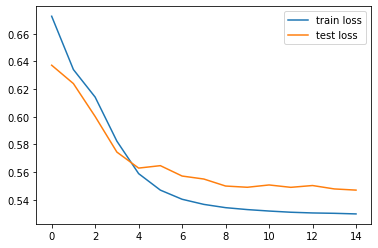

In [22]:
# plot losses
plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="test loss")
plt.legend()
plt.show()